In [28]:
import sounddevice as sd
from scipy.io.wavfile import write
import sounddevice as sd
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftshift, ifft, fftfreq
import numpy as np
import simpleaudio as sa
import wave
from scipy.signal import chirp, correlate
import math, cmath
from scipy import stats
import audioFunctions

In [29]:
# Function to display something quickly
def plot_y(y):
    x = np.linspace(0, len(y), len(y))
    plt.plot(x, y)
    plt.show

In [30]:
fs = 44100  # 44100 samples per second
sd.default.samplerate = 44100  # Sample rate
sd.default.channels = 1

# Recording sound
def record_and_save(filename, seconds):
    myrecording = sd.rec(int(seconds * sd.default.samplerate))
    print("recording")
    sd.wait()  # Wait until recording is finished
    print("writing")
    write(filename, fs, myrecording)  # Save as WAV file 
    print("done")
    return myrecording

# Recording sound and saving it as a wav file
def record(seconds):
    myrecording = sd.rec(int(seconds * sd.default.samplerate))
    print("recording")
    sd.wait()  # Wait until recording is finished
    print("done")
    return myrecording

# Play note on computer
def play_np_BT(note):
    # Ensure that highest value is in 16-bit range
    audio = note * (2**15 - 1) / np.max(np.abs(note))

    # Convert to 16-bit data
    audio = audio.astype(np.int16)

    # Start playback
    play_obj = sa.play_buffer(audio, 1, 2, fs)
    print("Playing note")
        
    # Wait for playback to finish before exiting
    play_obj.wait_done()
    print("done")

In [31]:
# Take a sequence of bits and returns a sequence of QPSK symbols half the length 
def qpsk(binary):
    assert len(binary)%2 == 0, "Binary string should have length multiple of 2"
    
    qam = []
    for i in range(int(len(binary)/2)):
        real = 1/math.sqrt(2)
        imaginary = 1/math.sqrt(2)*1j
        
        index = i*2
        if binary[index] == '1':
            imaginary *= -1
        
        if binary[index+1] == '1':
            real *= -1
            
        qam.append(real + imaginary)
        
    return np.asarray(qam)

In [32]:
# given a complex number constellation return the constellation (0,1,2,3)
def decode_qpsk(complex_number):
    Re = complex_number.real
    Im = complex_number.imag

    if Re > 0 and Im > 0:
        symbol = 0
    elif Re < 0 and Im > 0:
        symbol = 1
    elif Re < 0 and Im < 0:
        symbol = 2
    else:
        symbol = 3
        
    return symbol

In [39]:
# Produces a number of series for different uses with some variant of channel encoding
# Assume 1024 point DFT
maximum_freq_index = 200 # will not add any information bits after this value 
repetition_length = 5
def encoded_series(binary, qam, CP):
    assert 1024>=CP, "CP must be <= n"
    
    # Get QPSK constellation from the binary sequence
    constellation = qam(binary)
    
    assert len(constellation)%4 == 0, "Input must be byte (ie length is multiple of 8)"
    ### Perform channel encoding here
    
    max_freq_index = maximum_freq_index # will not add any information bits after this value 
    repetition = repetition_length
    
    # Now split the coded constellation into chunks for the iFFT including the coding method
    chunks = []
    new_chunk = True
    num_of_byte = int(len(constellation)/4)
    for i in range(num_of_byte):
        
        # repetition coding
        repeat = []
        for k in range(4):
            for j in range(repetition):
                repeat.append(constellation[i*4+k])

        if new_chunk:
            coded_constellation = repeat
            new_chunk = False
        else:
            coded_constellation += repeat

        if len(coded_constellation) > max_freq_index:
            #print(i)
            chunks.append(coded_constellation)
            new_chunk = True
           
        # if chunk is too small and the for loop ends, just append it
        if i == num_of_byte - 1:
            chunks.append(coded_constellation)
        
   
    for chunk in chunks:
        padding = 511-len(chunk)
        #print(len(chunk), "blah")
        for i in range(padding):
            # not sure what to add on these blocks... update: works very well removing high freq stuff
            chunk.append(cmath.rect(0.1,0))#cmath.rect(1, math.pi/4))
        
    
    time_series = []
    long_series = None
    freq_series = []
    for i, chunk in enumerate(chunks):
        chunk = np.asarray(chunk)
        chunk2 = chunk[::-1].conjugate()
        chunk_combined = np.concatenate(([0],chunk, [0],chunk2))
        
        freq_series.append(chunk_combined)
        
        time_chunk = ifft(chunk_combined).real
        time_chunk = np.concatenate((time_chunk[-1*CP:], time_chunk))
        
        single_msg = time_chunk*(2**15 - 1) / np.max(np.abs(time_chunk))
    
        time_series.append(single_msg)
        if i == 0:
            long_series = single_msg
            
        else:
            long_series = np.concatenate((long_series, single_msg))
        
    return time_series, long_series, freq_series


In [40]:
# Open a text file in the appropirate directory and then convert it into a binary sequence
file = open("KisekiTesting/untitled.txt")
line = file.read().replace("\n", " ")
file.close()

binary = '0' + bin(int.from_bytes(line.encode(), 'big'))[2:]
print(len(binary))

2392


In [41]:
T, L, F = encoded_series(binary, qpsk, 1024)
print(np.asarray(T).shape)

print(len(T[0]))
#plot_y(T[0])

(28, 2048)
2048


(2048,)
(28, 40960)
Playing note
done


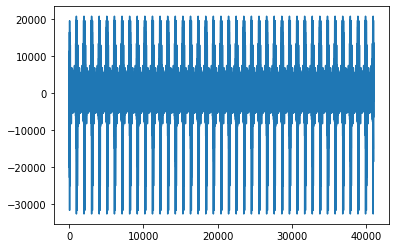

In [42]:
# Create an appropriate wav file with the chirp appended

sec = 1
t = np.linspace(0, sec, sec * fs)
h = chirp(t, f0=2000, f1=4000, t1=sec, method='linear')

scaled = np.int16(h/np.max(np.abs(h)) * 32767)

one_sec_zeros = np.zeros(fs)


# Make a repeated sequence of the time domain signals 
T_many_times = []
for i in range(20):
    for j in range(len(T)):
        
        if i ==0:
            T_many_times.append(T[j])
        else:
            T_many_times[j] = np.concatenate((T_many_times[j], T[j]))

print(T[0].shape)
print(np.asarray(T_many_times).shape)
plot_y(T_many_times[1])
    
out = np.concatenate((scaled,one_sec_zeros,T_many_times[5],T_many_times[0],T_many_times[1],one_sec_zeros))
write('chirp_signal_4.wav', 44100, out)

play_np_BT(out)


In [20]:
# record for some seconds
sd.default.device = "Built-in Microphone"
y = record_and_save('KisekiTesting/recording.wav', 6)

recording
writing
done


Playing note
done


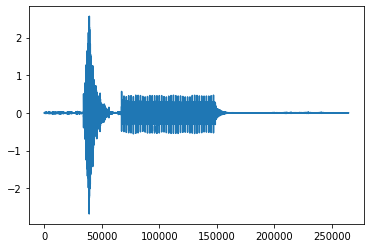

In [43]:
plot_y(y)
play_np_BT(y)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """


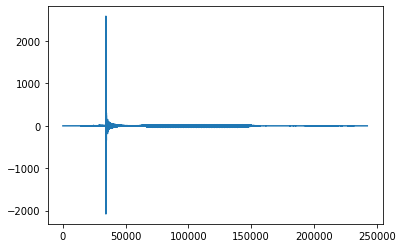

In [44]:
data = np.reshape(y, y.size)

# Chirp for matched filter NB should be same as the transmitted chirp!
sec = 0.5
t = np.linspace(0, sec, sec * fs)
h = chirp(t, f0=500, f1=20500, t1=sec, method='linear')

h_rev = h[::-1]

g = np.convolve(data, h_rev, 'valid')
plot_y(g) # plot matched filter output

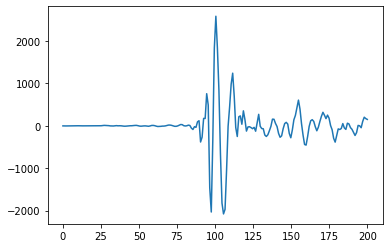

In [45]:
dh = len(h_rev)

i_max = np.argmax(g)

rng = 100
k = g[i_max - rng:i_max + rng]

plot_y(k)

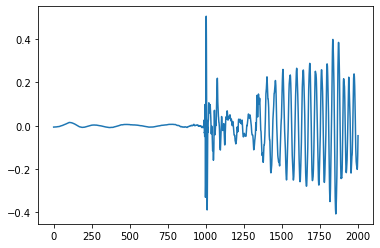

In [46]:
rng2 = 1000
cntr = int(i_max)
plot_y(y[cntr - rng2:cntr  + rng2])

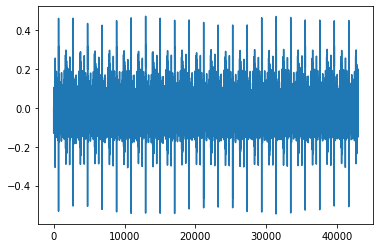

In [47]:
repeat = 20
dft = 2048 # N + K
time_start_index = cntr + dh + 44100 + dft*0
time = y[time_start_index-1000:time_start_index+repeat*dft + 1000]

plot_y(time)

6 8
max  301.437019005287 i_max  606 real i_max  605.0


/usr/local/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


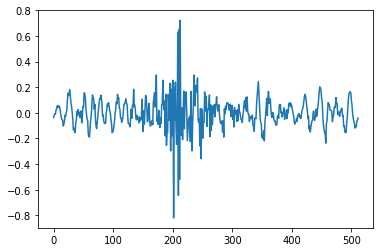

In [48]:
time_data = y[time_start_index:]
dft = 2048

samples = []
freq = []


timeshift = 1024
for i in range(repeat):
    samples.append(time_data[dft*i:dft*(i+1)][timeshift:timeshift+1024])
    samples[i] = np.reshape(samples[i],np.zeros(1024).shape)
    freq.append(fft(samples[i]))
    
known = F[5]
Phase = np.zeros(511)
for freq_response in freq:
    
    for i in range(1,int(len(freq_response)/2)):
        div = (freq_response[i]/known[i] )
        Phase[i-1] += cmath.phase(div)        
        
Phase = [x/repeat for x in Phase]

max_conv = []
for s in range(1000):
    P = []
    coeff = -0.01-s*0.001
    n = 0
    sign = coeff/abs(coeff)
    for i in range(1,511):
        val = math.pi * coeff * i - sign *2*math.pi*n

        if sign > 0:
            if val > math.pi:
                val = val - 2*math.pi
                n += 1
        else:
            if val < -1*math.pi:
                val = val + 2*math.pi
                n += 1   
                
        P.append(val)
        
    max_conv.append( max(correlate(P, Phase)))

max_conv = np.asarray(max_conv)
i_max = np.argmax(max_conv)
max_conv_max = np.max(max_conv)

count_up = 0
count_down = 0
cutoff = 0.75
for i in range(100):
    if max_conv[i_max+i] > max_conv_max*cutoff:
        count_up +=1
    
    if max_conv[i_max-i] > max_conv_max*cutoff:
        count_down +=1

print(count_up, count_down)

real_imax = i_max + (count_up - count_down)/2


#plot_y(max_conv[600:700])
print("max ", max_conv_max, "i_max ", i_max, "real i_max ", real_imax)


TF = np.zeros(511,dtype=complex)
TF_without_rotation = np.zeros(511,dtype=complex)
for freq_response in freq:
    
    for i in range(1,int(len(freq_response)/2)):
        div = (freq_response[i]/known[i] ) * cmath.rect(1, math.pi* (0.01+(real_imax-20)*0.001) * i)
        div2 = (freq_response[i]/known[i] )
        TF[i-1] += div 
        TF_without_rotation[i-1] += div2
        
TF = [x/repeat for x in TF]
TF_without_rotation = [x/repeat for x in TF_without_rotation]

impulse = ifft(TF)
plot_y(impulse)

In [49]:
time_start_index_content = time_start_index+repeat*dft
time_data_content = y[time_start_index_content:]

# how many chunks of 1024 symbols you sent
responses = []
for n in range(2):
    samples_content = []
    freq_content = []

    # get the FFT of the data
    for i in range(repeat):
        samples_content.append(time_data_content[n*dft*repeat + dft*i:n*dft*repeat +dft*(i+1)][timeshift:timeshift+1024])
        samples_content[i] = np.reshape(samples_content[i],np.zeros(1024).shape)
        freq_content.append(fft(samples_content[i]))


    TF_use = TF_without_rotation
    response = np.zeros(511, dtype = complex)
    for freq_response in freq_content:

        for i in range(1,int(len(freq_response)/2)):
            div = (freq_response[i]/ TF_use[i-1]) / cmath.rect(1, math.pi* (0.01+(real_imax)*0.001) * i)
            div2 = (freq_response[i]/TF_use[i-1] )

            response[i-1] += div2

    response = np.asarray([x/repeat for x in response])
    responses.append(response)

In [50]:
# Decoding
cutoff = maximum_freq_index-maximum_freq_index%repetition_length*8 + repetition_length*8

recovery = []
for n in range(2):
    
    relevant_data = responses[n][:cutoff]

    print(len(relevant_data))

    recovered_symbols = []
    for i in range(int(len(relevant_data)/repetition_length)):

        a = relevant_data[i*repetition_length:(i+1)*repetition_length]

        sequence = []
        for j in range(repetition_length):
            sequence.append(decode_qpsk(a[j]))

        print(sequence, end = '')
        print(stats.mode(sequence)[0])
        recovered_symbols.append(stats.mode(sequence)[0])


    # Check with transmited symbols:
    transmitted_symbols = []
    F_ref = F[n][1:]
    for i in range(int(len(relevant_data)/repetition_length)):

        a = F_ref[i*repetition_length:(i+1)*repetition_length]

        sequence = []
        for j in range(repetition_length):
            sequence.append(decode_qpsk(a[j]))

        transmitted_symbols.append(stats.mode(sequence)[0])


    match_count = [0,0,0]
    for i in range(len(recovered_symbols)):
        #print(recovered_symbols[i], transmitted_symbols[i])
        if recovered_symbols[i] == transmitted_symbols[i]:
            #print("Match!")
            match_count[0] += 1
            match_count[2] += 1
        else:
            #print("no match....")
            match_count[1] += 1
            match_count[2] += 1

    print("Percent successful = ", 100*match_count[0]/match_count[2])
    
    recovery.append(recovered_symbols)

240
[1, 0, 0, 0, 1][0]
[1, 3, 3, 3, 3][3]
[0, 0, 0, 0, 1][0]
[2, 2, 2, 2, 2][2]
[1, 1, 1, 1, 1][1]
[3, 3, 3, 3, 3][3]
[3, 3, 3, 3, 3][3]
[1, 1, 1, 1, 1][1]
[1, 1, 1, 1, 1][1]
[3, 3, 3, 3, 3][3]
[1, 1, 1, 1, 1][1]
[1, 1, 1, 1, 1][1]
[1, 1, 1, 1, 1][1]
[3, 0, 3, 3, 3][3]
[2, 2, 2, 2, 2][2]
[3, 3, 3, 3, 3][3]
[1, 1, 1, 1, 1][1]
[2, 2, 2, 2, 2][2]
[1, 1, 1, 1, 1][1]
[0, 0, 0, 0, 0][0]
[0, 0, 0, 0, 0][0]
[3, 3, 3, 3, 3][3]
[0, 0, 0, 0, 0][0]
[0, 0, 0, 0, 0][0]
[1, 1, 1, 1, 1][1]
[0, 0, 0, 0, 0][0]
[3, 3, 3, 3, 3][3]
[0, 0, 0, 0, 0][0]
[1, 1, 1, 1, 1][1]
[3, 3, 3, 3, 3][3]
[1, 1, 1, 1, 1][1]
[1, 1, 1, 1, 1][1]
[1, 1, 1, 1, 1][1]
[3, 3, 3, 3, 3][3]
[0, 0, 0, 0, 0][0]
[3, 3, 3, 3, 3][3]
[1, 1, 1, 1, 1][1]
[2, 2, 2, 2, 2][2]
[0, 0, 0, 0, 0][0]
[3, 3, 3, 3, 3][3]
[1, 1, 1, 1, 1][1]
[3, 3, 3, 3, 3][3]
[1, 1, 1, 1, 1][1]
[1, 1, 1, 1, 1][1]
[0, 0, 0, 0, 0][0]
[0, 0, 0, 0, 0][0]
[0, 0, 0, 0, 0][0]
[0, 0, 0, 0, 0][0]
Percent successful =  43.75
240
[3, 0, 1, 3, 0][0]
[2, 1, 0, 1, 1][1]
[0, 2, 3, 2, 2

In [51]:
# Symbols to binary 
def qpsk_decoded_to_binary(decode_list):
    binary = ""
    
    for item in decode_list:
        if item == 0:
            binary += "00"
        elif item == 1:
            binary += "01"
        elif item == 2:
            binary += "11"
        else:
            binary += "10"
            
    return binary

In [52]:
recovered_binary = ''
for rec in recovery:
    recovered_binary += qpsk_decoded_to_binary(rec)
    
print(recovered_binary)

001000110110100101100101011011100111010000100000010010000110010101100010011100100110010100000000000111000010010100000001001010111001000101110111010100000101100001001010010001000011010010011101


In [53]:
n = int(recovered_binary, 2)
out = n.to_bytes((n.bit_length() + 7) // 8, 'big').decode()

print(out)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x91 in position 16: invalid start byte